# 🏢 Berlin Airbnb Market Health Report (Sept 2025)
**Project Objective:** Analyzing the "Utility Gap" and rental supply in Berlin to provide investment insights for 2026.

## 📥 1. Data Acquisition
We are using the September 2025 'Inside Airbnb' dataset for Berlin. This provides the most recent snapshot of the housing market post-summer season.

In [1]:

import pandas as pd

df = pd.read_csv('/kaggle/input/berlin-airbnb-dataset-2025-september/listings.csv')

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53471,13.41810,Entire home/apt,105.0,63,150,2025-08-09,0.76,1,140,2,First name and Last name: Nicolas Krotz <br/> ...
1,9991,Geourgeous flat - outstanding views,33852,Philipp,Pankow,Prenzlauer Berg Südwest,52.53269,13.41805,Entire home/apt,135.0,6,7,2020-01-04,0.06,1,241,0,03/Z/RA/003410-18
2,14325,Studio Apartment in Prenzlauer Berg,55531,Chris + Oliver,Pankow,Prenzlauer Berg Nordwest,52.54813,13.40366,Entire home/apt,75.0,150,26,2023-11-30,0.14,4,168,0,NaN
3,17904,Beautiful Kreuzberg studio - 3 months minimum,68997,Matthias,Neukölln,Reuterstraße,52.49419,13.42166,Entire home/apt,32.0,93,298,2025-09-02,1.57,1,72,1,NaN
4,20858,Designer Loft in Berlin Mitte,71331,Marc,Pankow,Prenzlauer Berg Südwest,52.53711,13.40888,Entire home/apt,202.0,3,140,2025-07-16,0.89,1,253,4,03/Z/RA/009767-24


## 2. Data Cleaning: Currency & Type Conversion
Raw data is stored as text. To perform calculations, we use RegEx to remove symbols and convert the column to a numerical format.

In [2]:

# Identify the mess (Symbols in the price) and Clean the mess (The .replace code)
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Find the average price of an Airbnb in Berlin right now
avg_price = df['price'].mean()

print(f"The average price in Berlin (Sept 2025) is: €{avg_price:.2f}")

The average price in Berlin (Sept 2025) is: €201.24


**Cleaning the data**

In [3]:
# 1. Check how many missing values are in each column
missing_data = df.isnull().sum()

# 2. Fill missing 'reviews_per_month' with 0 (because no reviews means 0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# 3. Drop rows where 'neighbourhood' is missing (because we can't analyze location without it)
df = df.dropna(subset=['neighbourhood'])

print("Missing values handled! Your data is now 'clean'.")

Missing values handled! Your data is now 'clean'.


**Checking the column names**

In [4]:
print(df.columns.tolist())

['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']


**Understanding the Average availability (days per year) in Tourist Hubs**

In [5]:
# Filter data for the two main tourist hubs
hubs = df[df['neighbourhood_group'].isin(['Mitte', 'Friedrichshain-Kreuzberg'])]

# Calculate average availability for the next year
supply_stats = hubs.groupby('neighbourhood_group')['availability_365'].mean()

print("Average availability (days per year) in Tourist Hubs:")

print(supply_stats)


Average availability (days per year) in Tourist Hubs:
neighbourhood_group
Friedrichshain-Kreuzberg    132.404118
Mitte                       154.196325
Name: availability_365, dtype: float64


## 🏗️ 3. Feature Engineering: The "Utility Gap"
In the German market, understanding the difference between **Kaltmiete** (Base) and **Warmmiete** (Total) is vital. We are simulating a 20% utility cost to model real-world rental overheads.

In [6]:
# Assuming 'price' is the 'Warmmiete' (total cost)
# We calculate 'Kaltmiete' (Base Rent) by subtracting estimated utility costs (approx 20%)

# 1. Create the Kaltmiete (Cold Rent) - 80% of total price
df['kaltmiete'] = df['price'] * 0.80

# 2. Create the Utilities (Nebenkosten) - 20% of total price
df['utilities'] = df['price'] * 0.20

# 3. Rename 'price' to 'warmmiete' to be professionally accurate
df = df.rename(columns={'price': 'warmmiete'})

# Show the new columns
df[['neighbourhood_group', 'kaltmiete', 'utilities', 'warmmiete']].head()

,neighbourhood_group,kaltmiete,utilities,warmmiete
0,Pankow,84.0,21.0,105.0
1,Pankow,108.0,27.0,135.0
2,Pankow,60.0,15.0,75.0
3,Neukölln,25.6,6.4,32.0
4,Pankow,161.6,40.4,202.0


**Find which districts have the highest estimated utility costs**

In [7]:
utility_analysis = df.groupby('neighbourhood_group')['utilities'].mean().sort_values(ascending=False)

print("Average Monthly Utility Estimates (Nebenkosten) by District:")
print(utility_analysis)

Average Monthly Utility Estimates (Nebenkosten) by District:
neighbourhood_group
Mitte                       83.415656
Treptow - Köpenick          38.607982
Pankow                      31.369537
Charlottenburg-Wilm.        27.911426
Tempelhof - Schöneberg      27.816928
Friedrichshain-Kreuzberg    25.556649
Neukölln                    25.152120
Lichtenberg                 24.011200
Spandau                     22.824348
Steglitz - Zehlendorf       21.845455
Reinickendorf               21.744516
Marzahn - Hellersdorf       19.309091
Name: utilities, dtype: float64


## 📊 4. Market Visualizations
Comparing the average cost across Berlin's top neighborhoods to identify high-value investment zones.

**Top 5 Most Expensive Neighborhoods (Sept 2025)**

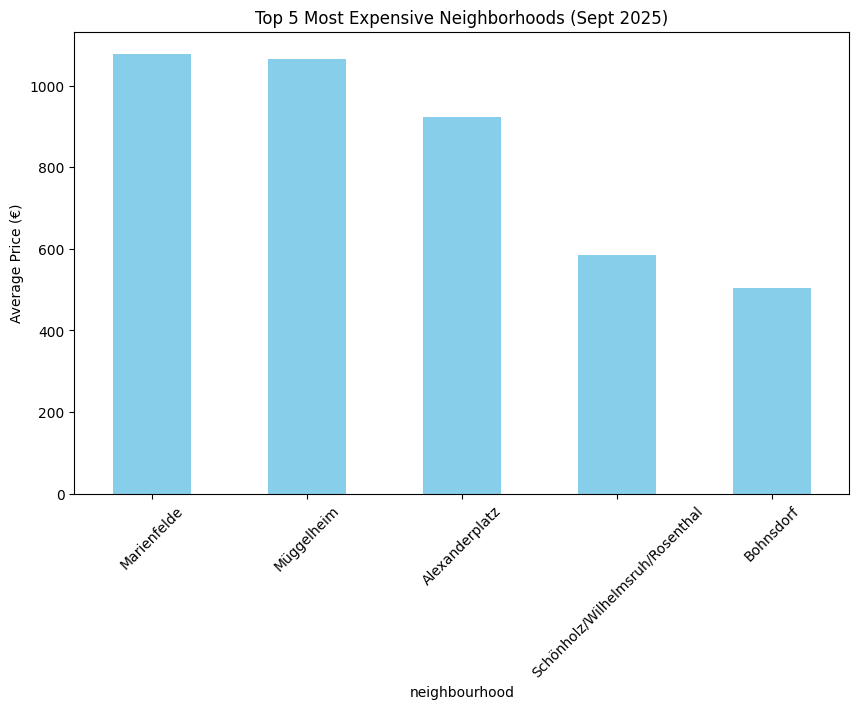

In [8]:
import matplotlib.pyplot as plt

# Create a small summary for a chart
top_districts = df.groupby('neighbourhood')['warmmiete'].mean().sort_values(ascending=False).head(5)

# Plotting
plt.figure(figsize=(10,6))
top_districts.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Expensive Neighborhoods (Sept 2025)')
plt.ylabel('Average Price (€)')
plt.xticks(rotation=45)
plt.show()

**Price Distribution Across Top Berlin Neighborhoods (Sept 2025)**

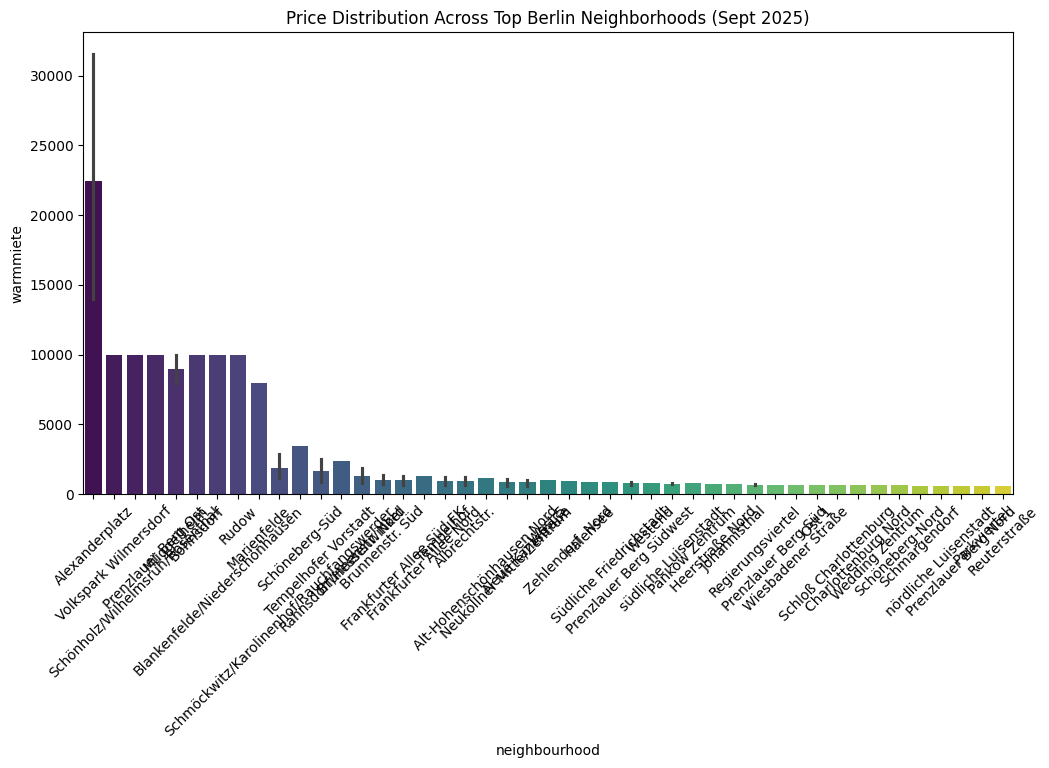

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a chart of the Top 10 neighborhoods by price
plt.figure(figsize=(12,6))

# Fix: We add 'hue' and set 'legend' to False to remove the warning
sns.barplot(
    data=df.nlargest(100, 'warmmiete'), 
    x='neighbourhood', 
    y='warmmiete', 
    hue='neighbourhood', 
    palette='viridis', 
    legend=False
)

plt.title('Price Distribution Across Top Berlin Neighborhoods (Sept 2025)')
plt.xticks(rotation=45)
plt.show()